In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score,
    classification_report, confusion_matrix,
    PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Opciones de pandas para visualización
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [2]:
df= pd.read_csv("processed.cleveland.data")
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Limpiar: reemplazar '?' por NaN y convertir a numérico
df = df.replace('?', np.nan)
for c in df.columns:
    # intentar convertir a numérico; si falla, lo deja como está
    df[c] = pd.to_numeric(df[c], errors='ignore')

# Crear target binario: en UCI 'num' es 0 (sano) o 1..4 (grados de enfermedad). Lo binarizamos.
if 'num' in df.columns:
    df['target'] = (df['num'] > 0).astype(int)
    # Quitamos la columna original multi-clase para evitar confusiones
    df = df.drop(columns=['num'], errors='ignore')

print("Forma del DataFrame:", df.shape)
display(df.head())


Forma del DataFrame: (302, 14)


/var/folders/j9/vw8n5h8j7lzbcpd4gp5z5r280000gn/T/ipykernel_8797/3209222172.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


Información general:
<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 300
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    float64
 1   sex       296 non-null    float64
 2   cp        296 non-null    float64
 3   trestbps  296 non-null    float64
 4   chol      296 non-null    float64
 5   fbs       296 non-null    float64
 6   restecg   296 non-null    float64
 7   thalach   296 non-null    float64
 8   exang     296 non-null    float64
 9   oldpeak   296 non-null    float64
 10  slope     296 non-null    float64
 11  ca        296 non-null    float64
 12  thal      296 non-null    float64
 13  target    296 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.7 KB
None

Nulos por columna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal      

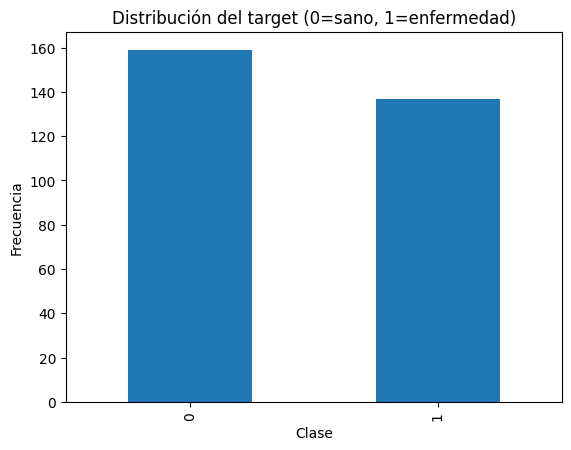

In [8]:
# === EDA breve ===
# Revisamos tipos, presencia de nulos y distribución del target.

numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

print("Información general:")
print(df.info())

df.replace('?', np.nan, inplace=True)
df = df.dropna(subset=['ca', 'thal'])
print("\nNulos por columna:")
print(df.isna().sum())

print("\nDistribución del target (0=sano, 1=enfermedad):")
print(df['target'].value_counts(dropna=False))
print("Proporciones:\n", df['target'].value_counts(normalize=True))

# Gráfico simple de la distribución del target
fig = plt.figure()
( df['target'].value_counts().sort_index().plot(kind='bar') )
plt.title("Distribución del target (0=sano, 1=enfermedad)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()


In [9]:
# === Preparación de datos ===

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("scaler", OneHotEncoder(handle_unknown="ignore")) # handle_unknown ignora categorias que
    # no aparecieron en el dataset
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, [c for c in numeric_features if c in df.columns]),
    ("cat", categorical_transformer, [c for c in categorical_features if c in df.columns])
], remainder="drop") # Con remainder="drop" asegura que solo se usen las variables seleccionadas y transformadas.

# Separar X e y
X = df.drop(columns=['target'])
y = df['target']

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Escalado estándar para modelos con regularización (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Train / Test split estratificado
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print("Tamaños:", X_train.shape, X_test.shape)


Tamaños: (222, 13) (74, 13)


## Regresión Logística 

=== Métricas en test ===
Accuracy: 0.8648648648648649
Precision: 0.8529411764705882
Recall: 0.8529411764705882
F1: 0.8529411764705882
ROC-AUC: 0.924264705882353
PR-AUC: 0.8864135670109896


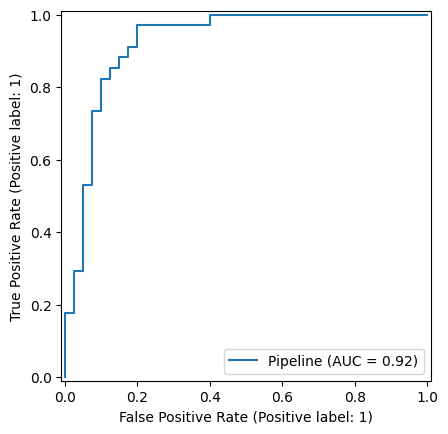

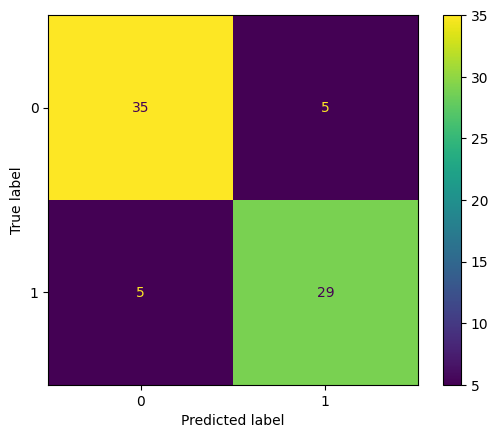

In [10]:
# ===== 7. Entrenar modelo lineal (sin regularización) =====

logit = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42))
])# Usamos solver="lbfgs", un algoritmo de optimización quasi-Newton eficiente y estable para regresión logística.
# Es recomendado por defecto en scikit-learn, soporta penalty=None y L2 (no L1/Elastic Net).

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]
# predict_proba devuelve [P(clase=0), P(clase=1)] para cada muestra.
# [:, 1] selecciona la probabilidad de la clase positiva (enfermedad = 1).

print("=== Métricas en test ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

RocCurveDisplay.from_estimator(logit, X_test, y_test)
plt.show()
ConfusionMatrixDisplay.from_estimator(logit, X_test, y_test)
plt.show()

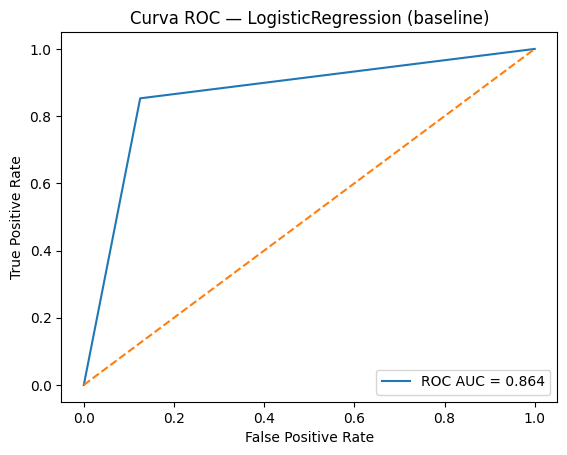

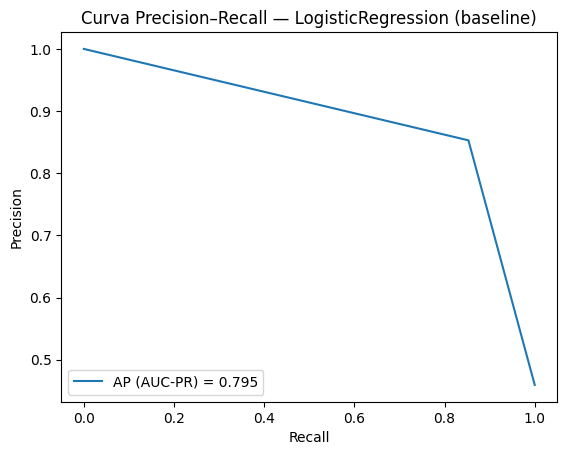

In [14]:
# === Curvas ROC y Precision–Recall para el baseline sklearn ===
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig = plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — LogisticRegression (baseline)")
plt.legend(loc="lower right")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

fig = plt.figure()
plt.plot(rec, prec, label=f"AP (AUC-PR) = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — LogisticRegression (baseline)")
plt.legend(loc="lower left")
plt.show()


In [16]:
# === Regularización con validación cruzada (sklearn) ===
# Comparamos L2 (Ridge), L1 (Lasso) y Elastic Net.
# ===== 8. Entrenar el modelo lineal con regularización: L1, L2 y Elastic Net con validación cruzada =====
# L2 (Ridge)
ridge_cv = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegressionCV(
        penalty="l2", solver="lbfgs",
        scoring="f1", max_iter=5000
    ))
])
ridge_cv.fit(X_train, y_train)

# L1 (Lasso)
lasso_cv = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegressionCV(
        penalty="l1", solver="saga",
        scoring="f1", max_iter=5000
    ))
])
lasso_cv.fit(X_train, y_train)

# Elastic Net
elastic_cv = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegressionCV(
        penalty="elasticnet", solver="saga", l1_ratios=[0.5], 
        scoring="f1", max_iter=5000
    ))
])
elastic_cv.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('clf',
                 LogisticRegressionCV(l1_ratios=[0.5], max_iter=5000,
                                      penalty='elasticnet', scoring='f1',
                                      solver='saga'))])

In [24]:
# === Comparación de coeficientes: baseline sklearn vs mejor regularizado ===

# Extraer nombres de features finales
ohe = logit.named_steps["preprocess"].named_transformers_["cat"].named_steps["scaler"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

coefs = logit.named_steps["clf"].coef_[0]
coef_table = pd.DataFrame({"feature": feature_names, "coef": coefs})
print("\nCoeficientes (sin regularización):")
display(coef_table.sort_values(by="coef", key=abs, ascending=False))


def eval_model(pipe, X_test, y_test, name="Modelo"):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    return {
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba)
    }

results = []
results.append(eval_model(ridge_cv, X_test, y_test, "L2 (Ridge)"))
results.append(eval_model(lasso_cv, X_test, y_test, "L1 (Lasso)"))
results.append(eval_model(elastic_cv, X_test, y_test, "Elastic Net"))

results_df = pd.DataFrame(results)
print("\n=== Comparación de modelos regularizados ===")
display(results_df)

# ===== 11. Tabla comparativa de coeficientes =====
coefs_ridge = ridge_cv.named_steps["clf"].coef_[0]
coefs_lasso = lasso_cv.named_steps["clf"].coef_[0]
coefs_elastic = elastic_cv.named_steps["clf"].coef_[0]

coef_compare = pd.DataFrame({
    "feature": feature_names,
    "sin_reg": coefs,
    "L2": coefs_ridge,
    "L1": coefs_lasso,
    "ElasticNet": coefs_elastic
})
print("\nCoeficientes comparados (sin regularizar vs regularizados):")
display(coef_compare.sort_values(by="sin_reg", key=abs, ascending=False))


Coeficientes (sin regularización):


,feature,coef
5,ca,1.072094
11,cp_0.8722797746640146,1.048818
24,thal_1.1736660357063287,0.894916
10,cp_-0.17304335610743585,-0.690239
6,sex_-1.4433756729740643,-0.647882
7,sex_0.6928203230275509,0.647634
22,thal_-0.8911490999196644,-0.504499
20,slope_0.6560383273595487,0.501626
17,exang_-0.6981670186492972,-0.441508
18,exang_1.4323220279506204,0.441259



=== Comparación de modelos regularizados ===


,Modelo,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,L2 (Ridge),0.864865,0.852941,0.852941,0.852941,0.922059,0.884508
1,L1 (Lasso),0.851351,0.848485,0.823529,0.835821,0.924265,0.883862
2,Elastic Net,0.864865,0.852941,0.852941,0.852941,0.925735,0.891839



Coeficientes comparados (sin regularizar vs regularizados):


,feature,sin_reg,L2,L1,ElasticNet
5,ca,1.072094,1.176925,0.820593,0.841228
11,cp_0.8722797746640146,1.048818,1.136688,1.221837,1.035797
24,thal_1.1736660357063287,0.894916,0.996305,1.090011,0.828989
10,cp_-0.17304335610743585,-0.690239,-0.766994,-0.144600,-0.403963
6,sex_-1.4433756729740643,-0.647882,-0.774321,-0.542172,-0.413809
7,sex_0.6928203230275509,0.647634,0.734275,0.124662,0.402724
22,thal_-0.8911490999196644,-0.504499,-0.469338,-0.073680,-0.390720
20,slope_0.6560383273595487,0.501626,0.572031,0.395743,0.348379
17,exang_-0.6981670186492972,-0.441508,-0.486156,-0.496159,-0.343055
18,exang_1.4323220279506204,0.441259,0.446109,0.040867,0.331970


## Interpretación (guía breve)

- **Signos y magnitudes**: en features **escaladas**, un coeficiente positivo indica que **al aumentar** esa variable (en desviaciones estándar), **aumenta** el log-odds de *enfermedad* (target=1). Coeficientes negativos indican el efecto contrario.
- **p-values (modelo sin regularización)**: ayudan a evaluar **significancia estadística** bajo supuestos del modelo. P-values pequeños sugieren evidencia de asociación con el outcome, pero **no garantizan causalidad**.
- **Regularización**:
  - **L2 (Ridge)**: encoge todos los coeficientes hacia 0, útil para multicolinealidad.
  - **L1 (Lasso)**: promueve **sparsity** (deja algunos coeficientes en 0), facilitando selección de variables.
  - **Elastic Net**: combina ambas (controlado por `l1_ratio`) y puede ser un buen **término medio**.
- **Métricas**:
  - Reportamos **Accuracy, Precision, Recall, F1, AUC-ROC y AUC-PR** en *test*, que permiten valorar el balance entre falsos positivos/negativos según el objetivo clínico.
- **Variables relevantes**: observe las filas superiores de la tabla de coeficientes (por magnitud absoluta) y cruce con p-values; las que muestren gran magnitud y/o significancia tienden a ser más **informativas** para el modelo.

> Recomendación: si el objetivo es **cribado** (screening), priorice **Recall**; si es **confirmación diagnóstica**, priorice **Precision**. Ajuste el umbral de decisión (por defecto 0.5) según la curva PR para su caso de uso.


== Mejor set de hiperparámetros (GridSearchCV) ==
{'ccp_alpha': 0.0005, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20}
Mejor AUC-ROC (CV): 0.8514

=== Métricas en test (árbol optimizado) ===
Accuracy: 0.8648648648648649
Precision: 0.8529411764705882
Recall: 0.8529411764705882
F1: 0.8529411764705882
ROC-AUC: 0.924264705882353
PR-AUC: 0.8864135670109896

Classification Report (test):
              precision    recall  f1-score   support

           0      0.762     0.800     0.780        40
           1      0.750     0.706     0.727        34

    accuracy                          0.757        74
   macro avg      0.756     0.753     0.754        74
weighted avg      0.756     0.757     0.756        74

Matriz de confusión (test):
[[32  8]
 [10 24]]


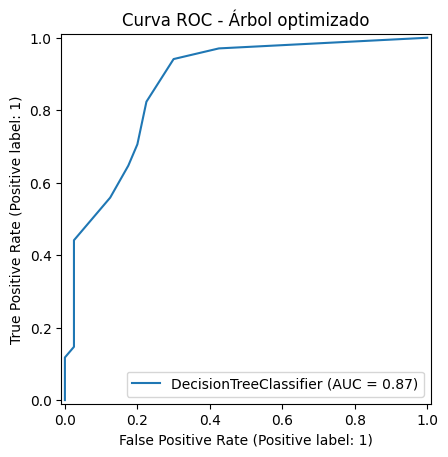

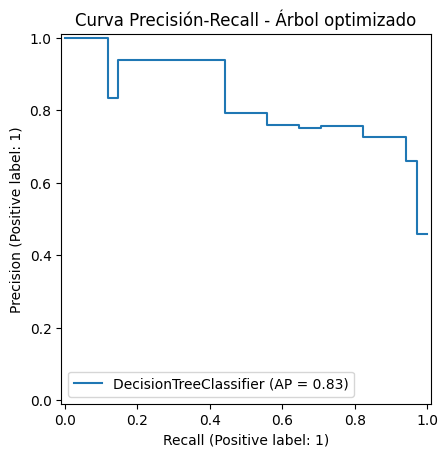


Top 10 importancias de variables:


,importance
ca,0.297322
oldpeak,0.273110
slope,0.113520
thal,0.112950
trestbps,0.087756
age,0.051637
cp,0.048594
chol,0.010948
thalach,0.004163
sex,0.000000


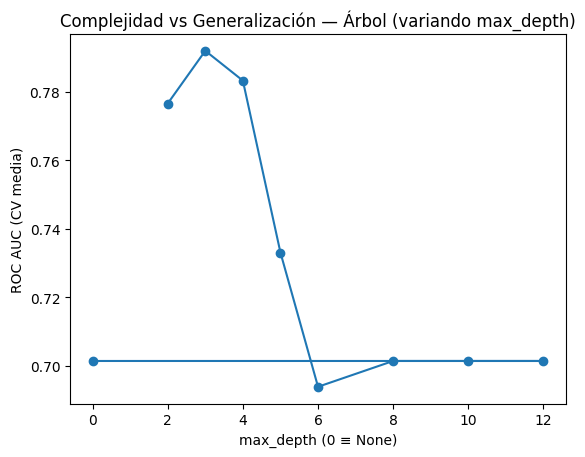

In [22]:
# =========================
# 2) Árbol de decisión
# =========================
# Objetivo:
# 1) Entrenar un DecisionTreeClassifier optimizando hiperparámetros con GridSearchCV.
# 2) Reportar importancias de variables y reglas del árbol final; extraer rutas de decisión.
# 3) Analizar complejidad vs generalización: efecto de max_depth y/o ccp_alpha.


# 2.1 Grid de hiperparámetros y búsqueda
best_tree = grid.best_estimator_
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "max_depth": [None, 3, 4, 5, 6, 8, 10, 12],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005, 0.01]
}

base_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=base_dt,
    param_grid=param_grid,
    scoring="roc_auc",     # métrica de selección en CV (coherente con §1)
    cv=cv,
    n_jobs=None,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)

print("== Mejor set de hiperparámetros (GridSearchCV) ==")
print(grid.best_params_)
print(f"Mejor AUC-ROC (CV): {grid.best_score_:.4f}")

best_dt = grid.best_estimator_


# 2.2 Métricas en test + importancias

y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
y_pred_dt  = (y_proba_dt >= 0.5).astype(int)


print("\n=== Métricas en test (árbol optimizado) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


print("\nClassification Report (test):")
print(classification_report(y_test, y_pred_dt, digits=3))

print("Matriz de confusión (test):")
print(confusion_matrix(y_test, y_pred_dt))


RocCurveDisplay.from_estimator(best_tree, X_test, y_test)
plt.title("Curva ROC - Árbol optimizado")
plt.show()

PrecisionRecallDisplay.from_estimator(best_tree, X_test, y_test)
plt.title("Curva Precisión-Recall - Árbol optimizado")
plt.show()

# Importancias de variables
feat_imp = pd.Series(best_dt.feature_importances_, index=X_train.columns, name="importance")
feat_imp = feat_imp.sort_values(ascending=False)
print("\nTop 10 importancias de variables:")
display(feat_imp.head(10).to_frame())

# 2.3 Reglas del árbol y rutas de decisión
"""
# Reglas globales (texto)
print("\n=== Reglas del árbol (export_text) ===")
rules_text = export_text(best_dt, feature_names=list(X_train.columns))
print(rules_text[:2000], "...")  # truncamos por si es muy largo

"""
# 2.4 Complejidad vs generalización (validación por max_depth)

depths = [2, 3, 4, 5, 6, 8, 10, 12, None]
depth_labels = [d if d is not None else 0 for d in depths]  # usar 0 para representar None en el eje

cv_scores = []
for d in depths:
    dt_tmp = DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=d
    )
    scores = cross_val_score(dt_tmp, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=None)
    cv_scores.append(scores.mean())

fig = plt.figure()
plt.plot(depth_labels, cv_scores, marker="o")
plt.xlabel("max_depth (0 ≡ None)")
plt.ylabel("ROC AUC (CV media)")
plt.title("Complejidad vs Generalización — Árbol (variando max_depth)")
plt.grid(False)
plt.show()




== Mejor set de hiperparámetros (Random Forest) ==
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Métricas en test (Random Forest):
accuracy     0.808989
precision    0.785714
recall       0.804878
f1           0.795181
auc_roc      0.890752
auc_pr       0.864580
dtype: float64

Classification Report (test):
              precision    recall  f1-score   support

           0      0.830     0.812     0.821        48
           1      0.786     0.805     0.795        41

    accuracy                          0.809        89
   macro avg      0.808     0.809     0.808        89
weighted avg      0.809     0.809     0.809        89

Matriz de confusión (test):
[[39  9]
 [ 8 33]]

Top 10 importancias (Gini):


,gini_importance
thal_7.0,0.142719
cp_4.0,0.134885
ca,0.108283
oldpeak,0.094369
age,0.081727
thalach,0.080310
trestbps,0.075709
chol,0.060055
exang,0.057021
cp_3.0,0.042651



Top 10 importancias (Permutation Importance, test):


,feature,importance_mean,importance_std
17,thal_7.0,0.047409,0.017335
8,ca,0.046138,0.019524
7,oldpeak,0.028557,0.009083
11,cp_4.0,0.014990,0.013475
5,thalach,0.014431,0.006039
1,sex,0.009604,0.006995
14,slope_2.0,0.003100,0.003785
6,exang,0.001880,0.006351
0,age,0.001372,0.006791
15,slope_3.0,0.000254,0.000468


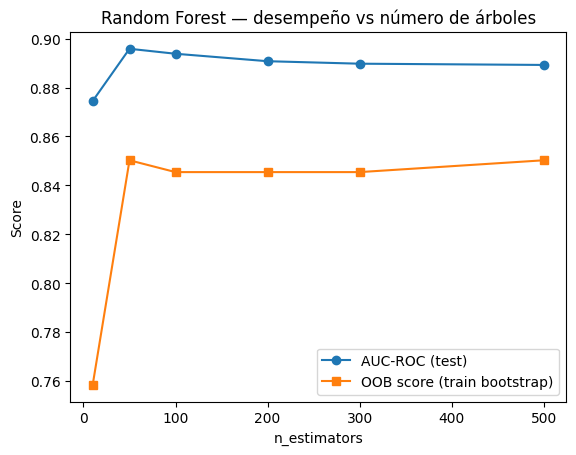

In [ ]:
# =========================
# 3) Random Forest (simple y robusto)
# =========================

def compute_all_metrics(y_true, y_proba, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc_roc": roc, "auc_pr": ap}

# -------------------------
# 3.1 GridSearchCV (sin OOB durante la búsqueda)
#    Importante: ponemos oob_score=False en el estimador base para evitar fallos con bootstrap=False
# -------------------------
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=False)

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=0,
    refit=True
)
grid_rf.fit(X_train, y_train)

print("== Mejor set de hiperparámetros (Random Forest) ==")
print(grid_rf.best_params_)

best_rf = grid_rf.best_estimator_

# -------------------------
# 3.2 Métricas en test
# -------------------------
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf  = (y_proba_rf >= 0.5).astype(int)

metrics_rf = compute_all_metrics(y_test, y_proba_rf, y_pred_rf)
print("\nMétricas en test (Random Forest):")
print(pd.Series(metrics_rf))

print("\nClassification Report (test):")
print(classification_report(y_test, y_pred_rf, digits=3))
print("Matriz de confusión (test):")
print(confusion_matrix(y_test, y_pred_rf))

# -------------------------
# 3.3 Importancias de variables
# -------------------------
# Gini importance
gini_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns, name="gini_importance").sort_values(ascending=False)
print("\nTop 10 importancias (Gini):")
display(gini_imp.head(10).to_frame())

# Permutation importance (en test) para contrastar posibles sesgos de Gini
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring="roc_auc")
perm_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)
print("\nTop 10 importancias (Permutation Importance, test):")
display(perm_df.head(10))

# -------------------------
# 3.4 Efecto de la cantidad de árboles (y OOB si aplica)
# -------------------------
# Para mostrar OOB sin errores, entrenamos SIEMPRE con bootstrap=True y oob_score=True en este experimento.
n_range = [10, 50, 100, 200, 300, 500]
test_auc = []
oob_scores = []

for n in n_range:
    rf_tmp = RandomForestClassifier(
        n_estimators=n,
        random_state=RANDOM_STATE,
        bootstrap=True,
        oob_score=True,   # OOB solo funciona si bootstrap=True
        max_depth=best_rf.max_depth,
        min_samples_split=best_rf.min_samples_split,
        min_samples_leaf=best_rf.min_samples_leaf,
        max_features=best_rf.max_features
    )
    rf_tmp.fit(X_train, y_train)
    y_prob_tmp = rf_tmp.predict_proba(X_test)[:, 1]
    test_auc.append(roc_auc_score(y_test, y_prob_tmp))
    oob_scores.append(rf_tmp.oob_score_)

fig = plt.figure()
plt.plot(n_range, test_auc, marker="o", label="AUC-ROC (test)")
plt.plot(n_range, oob_scores, marker="s", label="OOB score (train bootstrap)")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Random Forest — desempeño vs número de árboles")
plt.legend()
plt.show()


Top 10 importancias de variables:


,importance
ca,0.297322
oldpeak,0.273110
slope,0.113520
thal,0.112950
trestbps,0.087756
age,0.051637
cp,0.048594
chol,0.010948
thalach,0.004163
sex,0.000000


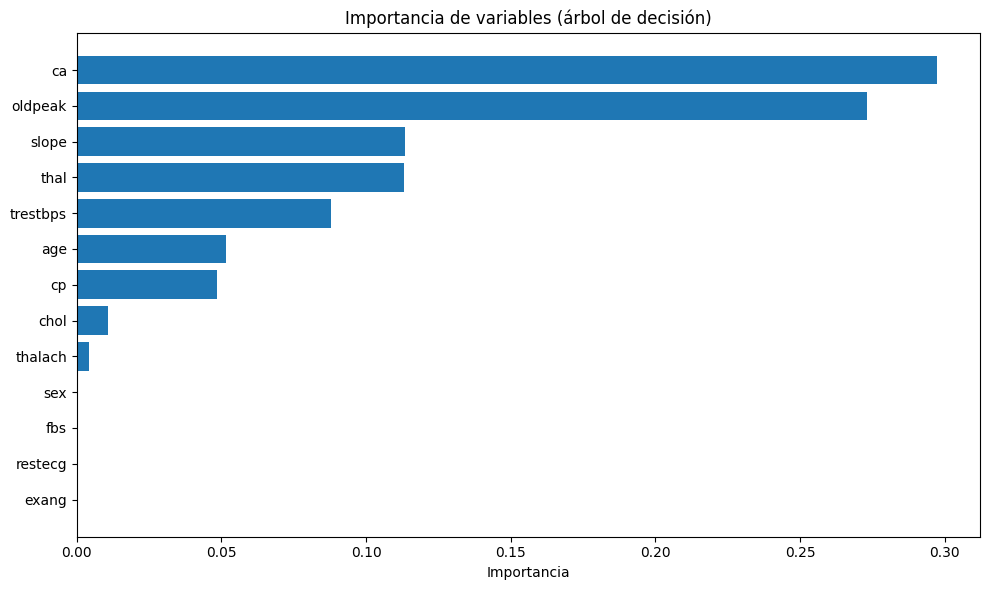

In [39]:
# Importancias usando las columnas efectivas del entrenamiento

feat_imp = pd.Series(
    best_dt.feature_importances_, 
    index=X_train.columns, 
    name="importance"
).sort_values(ascending=False)

print("Top 10 importancias de variables:")
display(feat_imp.head(10).to_frame())

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(feat_imp.index, feat_imp.values)   # <-- acá index = nombres, values = importancias
plt.gca().invert_yaxis()
plt.title("Importancia de variables (árbol de decisión)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()
